In [1]:
# Setup: imports and helpers
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

base = Path.cwd()
lat_dir = (base / "../latencies").resolve()
assert lat_dir.exists(), f"latencies directory not found: {lat_dir}"

# Readers


def read_lat_file(path: Path) -> np.ndarray:
    with path.open("r") as f:
        vals = [float(line.strip()) for line in f if line.strip()]
    return np.asarray(vals, dtype=float)


# Discovery
python_files = sorted(lat_dir.glob("python_*.lat"))
async_conn_files = sorted(lat_dir.glob("async_conn_*.lat"))
sync_conn_files = sorted(lat_dir.glob("sync_conn_*.lat"))

print(
    f"Found: python={len(python_files)}, async_conn={len(async_conn_files)}, sync_conn={len(sync_conn_files)}")


Found: python=1, async_conn=10, sync_conn=10


In [2]:
# Discover and parse all series dynamically (no hardcoded names)
import re
from datetime import datetime


def parse_all(lat_dir: Path):
    recs = []
    for p in lat_dir.iterdir():
        if not p.is_file():
            continue
        m = re.match(r"async_conn_(\d+)_(\d{8}_\d{6})\.lat$", p.name)
        if m:
            idx = int(m.group(1))
            ts = datetime.strptime(m.group(2), "%Y%m%d_%H%M%S")
            recs.append({
                "run_ts": ts,
                "kind": "async",
                "conn": idx,
                "path": p,
                "vals": read_lat_file(p),
            })
            continue
        m = re.match(r"sync_conn_(\d+)_(\d{8}_\d{6})\.lat$", p.name)
        if m:
            idx = int(m.group(1))
            ts = datetime.strptime(m.group(2), "%Y%m%d_%H%M%S")
            recs.append({
                "run_ts": ts,
                "kind": "sync",
                "conn": idx,
                "path": p,
                "vals": read_lat_file(p),
            })
            continue
        m = re.match(r"python_(\d{8}_\d{6})\.lat$", p.name)
        if m:
            ts = datetime.strptime(m.group(1), "%Y%m%d_%H%M%S")
            recs.append({
                "run_ts": ts,
                "kind": "python",
                "conn": None,
                "path": p,
                "vals": read_lat_file(p),
            })
            continue
    return recs


records = parse_all(lat_dir)

# Summary table over all discovered series
rows = []
for r in records:
    v = r["vals"]
    if v.size == 0:
        continue
    p50, p90, p99, p999 = np.percentile(v, [50, 90, 99, 99.9])
    label = f"{r['kind']}:{r['conn']}" if r["conn"] is not None else r["kind"]
    rows.append({
        "run_ts": r["run_ts"],
        "series": label,
        "file": r["path"].name,
        "count": v.size,
        "p50": p50,
        "p90": p90,
        "p99": p99,
        "p999": p999,
        "max": v.max(),
    })
summary = pd.DataFrame(rows).sort_values(
    ["run_ts", "series"]).reset_index(drop=True)
summary

# Latest-per-series map for downstream plots
series = {}
for r in sorted(records, key=lambda x: (x["kind"], x["conn"] if x["conn"] is not None else -1, x["run_ts"])):
    label = f"{r['kind']}:{r['conn']}" if r["conn"] is not None else r["kind"]
    series[label] = r["vals"]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


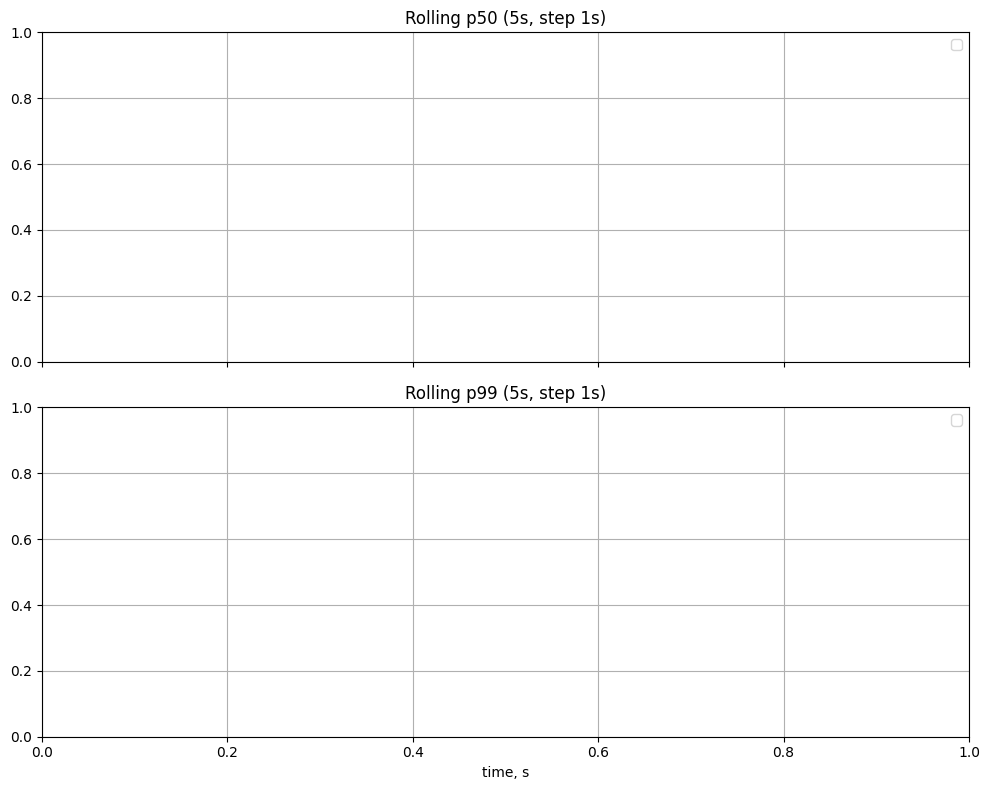

In [3]:
# Rolling percentiles (5s window, step 1s)
import math


def rolling_percentiles(vals: np.ndarray, freq=1000.0, window_s=5.0, step_s=1.0):
    if vals.size == 0:
        return pd.DataFrame()
    win = int(window_s * freq)
    step = int(step_s * freq)
    rows = []
    for start in range(0, len(vals)-win+1, step):
        window = vals[start:start+win]
        p50, p99 = np.percentile(window, [50, 99])
        rows.append({"t": start/freq, "p50": p50, "p99": p99})
    return pd.DataFrame(rows)


fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
for name in [k for k in series.keys() if k.startswith("async") or k.startswith("sync") or k == "python"]:
    df = rolling_percentiles(series[name])
    if df.empty:
        continue
    ax[0].plot(df["t"], df["p50"], label=f"{name}")
    ax[1].plot(df["t"], df["p99"], label=f"{name}")
ax[0].set_title("Rolling p50 (5s, step 1s)")
ax[1].set_title("Rolling p99 (5s, step 1s)")
ax[1].set_xlabel("time, s")
ax[0].legend()
ax[1].legend()
plt.tight_layout()


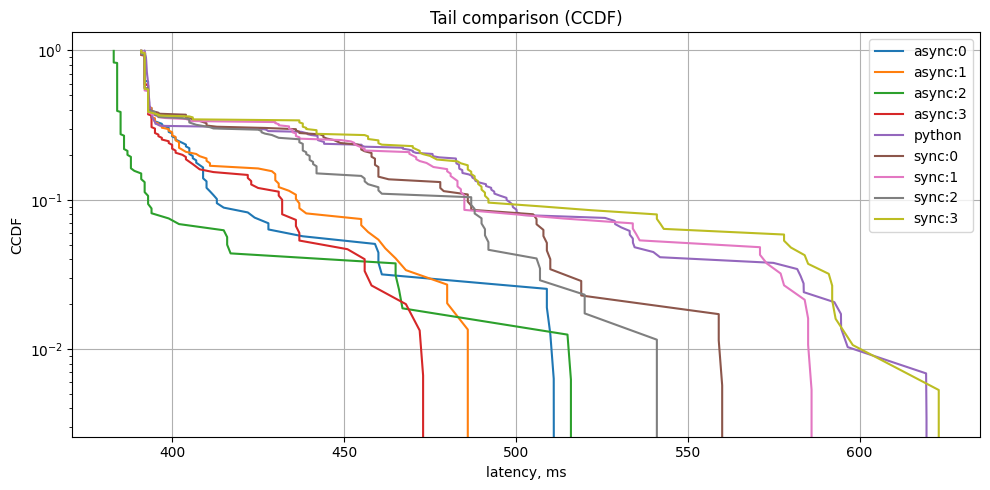

In [4]:
# CCDF tails (log-scale)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name, vals in series.items():
    if vals.size == 0:
        continue
    xs = np.sort(vals)
    ccdf = 1.0 - np.arange(1, xs.size+1)/xs.size
    ax.plot(xs, ccdf, label=name)
ax.set_yscale('log')
ax.set_xlabel('latency, ms')
ax.set_ylabel('CCDF')
ax.set_title('Tail comparison (CCDF)')
ax.legend()
plt.tight_layout()


/tmp/ipykernel_255678/1993346956.py:89: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df_all, x='series', y='lat_ms', order=order,


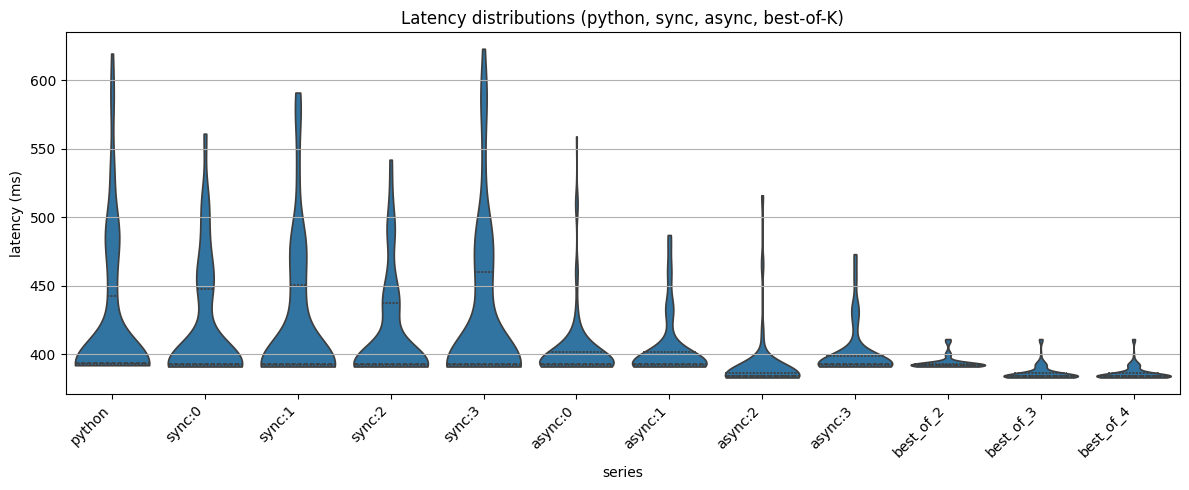

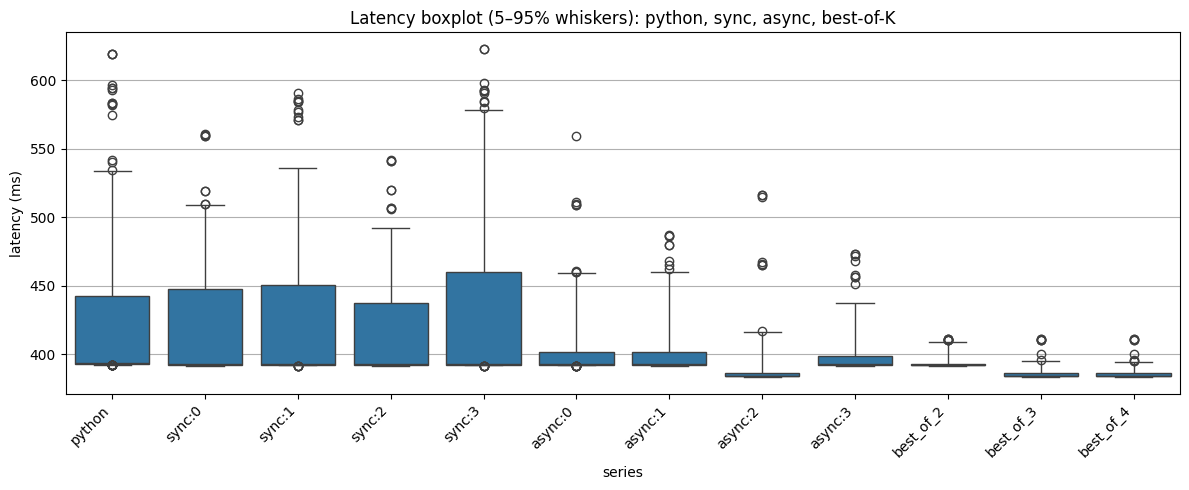

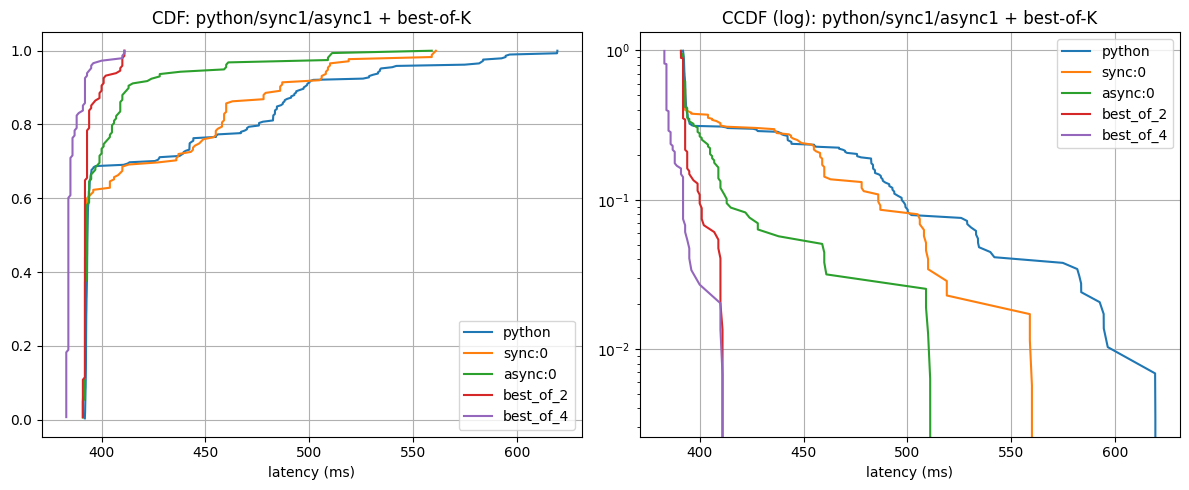

In [5]:
# Generalized distributions across async, sync, python + Best-of-K; violin/box/CDF/CCDF
import re

# Collect categories from 'series' (latest-per-series mapping built above)
async_items, sync_items, py_items = [], [], []
for name, vals in series.items():
    if vals is None or getattr(vals, 'size', 0) == 0:
        continue
    if name.startswith('async:'):
        try:
            idx = int(name.split(':')[1])
        except Exception:
            idx = 0
        async_items.append((idx, name, vals))
    elif name.startswith('sync:'):
        try:
            idx = int(name.split(':')[1])
        except Exception:
            idx = 0
        sync_items.append((idx, name, vals))
    elif name.startswith('python'):
        py_items.append((0, name, vals))

parts = []

# Async: add each connection
if len(async_items) > 0:
    async_items.sort(key=lambda x: x[0])
    async_labels = [nm for _, nm, _ in async_items]
    async_arrays = [v for _, _, v in async_items]
    for nm, v in zip(async_labels, async_arrays):
        parts.append(pd.DataFrame({'series': nm, 'lat_ms': v}))
    # Best-of-K (K up to 8 or up to available)
    Kmax = min(8, len(async_arrays))
    for K in range(2, Kmax+1):
        m = min(len(async_arrays[j]) for j in range(K))
        if m <= 0:
            continue
        stacked = np.vstack([async_arrays[j][:m] for j in range(K)])
        bestk = stacked.min(axis=0)
        parts.append(pd.DataFrame({'series': f'best_of_{K}', 'lat_ms': bestk}))
else:
    async_labels, Kmax = [], 0

# Sync: add each connection
if len(sync_items) > 0:
    sync_items.sort(key=lambda x: x[0])
    for _, nm, v in sync_items:
        parts.append(pd.DataFrame({'series': nm, 'lat_ms': v}))

# Python: add
if len(py_items) > 0:
    nm, v = py_items[0][1], py_items[0][2]
    parts.append(pd.DataFrame({'series': nm, 'lat_ms': v}))

if len(parts) == 0:
    print('No series found (async/sync/python).')
else:
    df_all = pd.concat(parts, ignore_index=True)

    # Series ordering: python -> sync:* (by idx) -> async:* (by idx) -> best_of_K
    def series_key(x):
        if x.startswith('python'):
            return (0, 0, x)
        if x.startswith('sync:'):
            try:
                idx = int(x.split(':')[1])
            except Exception:
                idx = 0
            return (1, idx, x)
        if x.startswith('async:'):
            try:
                idx = int(x.split(':')[1])
            except Exception:
                idx = 0
            return (2, idx, x)
        if x.startswith('best_of_'):
            try:
                idx = int(x.split('_')[-1])
            except Exception:
                idx = 0
            return (3, idx, x)
        return (4, 0, x)

    order = sorted(df_all['series'].unique(), key=series_key)

    # Violin plot
    plt.figure(figsize=(12, 5))
    sns.violinplot(data=df_all, x='series', y='lat_ms', order=order,
                   inner='quartile', cut=0, scale='width')
    plt.xticks(rotation=45, ha='right')
    plt.title('Latency distributions (python, sync, async, best-of-K)')
    plt.xlabel('series')
    plt.ylabel('latency (ms)')
    plt.tight_layout()

    # Boxplot
    plt.figure(figsize=(12, 5))
    sns.boxplot(data=df_all, x='series', y='lat_ms', order=order, whis=[5, 95])
    plt.xticks(rotation=45, ha='right')
    plt.title('Latency boxplot (5–95% whiskers): python, sync, async, best-of-K')
    plt.xlabel('series')
    plt.ylabel('latency (ms)')
    plt.tight_layout()

    # CDF and CCDF: compare baseline python/sync1/async1 and best-of-K
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    cdf_labels = []
    # python baseline (if present)
    py_names = [nm for nm in order if nm.startswith('python')]
    if len(py_names) > 0:
        cdf_labels.append(py_names[0])
    # first sync
    sync_names = [nm for nm in order if nm.startswith('sync:')]
    if len(sync_names) > 0:
        cdf_labels.append(sync_names[0])
    # first async
    async_names = [nm for nm in order if nm.startswith('async:')]
    if len(async_names) > 0:
        cdf_labels.append(async_names[0])
    # best-of-K lines
    for K in (2, 4, 8):
        label = f'best_of_{K}'
        if label in order:
            cdf_labels.append(label)

    for lbl in cdf_labels:
        vv = df_all.loc[df_all['series'] == lbl, 'lat_ms'].values
        if vv.size == 0:
            continue
        xs = np.sort(vv)
        cdf = np.arange(1, xs.size+1) / xs.size
        ax[0].plot(xs, cdf, label=lbl)
        ccdf = 1.0 - cdf
        ax[1].plot(xs, ccdf, label=lbl)

    ax[0].set_title('CDF: python/sync1/async1 + best-of-K')
    ax[0].set_xlabel('latency (ms)')
    ax[0].legend()
    ax[1].set_title('CCDF (log): python/sync1/async1 + best-of-K')
    ax[1].set_xlabel('latency (ms)')
    ax[1].set_yscale('log')
    ax[1].legend()
    plt.tight_layout()
